In [143]:
import os
from PIL import Image

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
import random
random.seed(10)


from cv2 import cv2
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras import layers, models

import matplotlib.cm as cm

from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented
from keras_unet.utils import plot_imgs
from keras.callbacks import ModelCheckpoint
from keras_unet.utils import plot_segm_history

from keras.metrics import BinaryAccuracy
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam


Wgrywanie danych

In [65]:
path = r"C:\Users\Odin\Desktop\Cardiac_Catheterization\Data\X_ray" # ZDJĘCIE RTG
path_masks = r"C:\Users\Odin\Desktop\Cardiac_Catheterization\Data\Masks" # Maski

data_x_ray = []
data_masks = []

data_dir_x_ray = os.path.join(path)
data_dir_masks = os.path.join(path_masks)


for file in os.listdir(os.path.join(data_dir_x_ray)):
    data_x_ray.append(['{}'.format(file)])

for file in os.listdir(os.path.join(data_dir_masks)):
    data_masks.append(['{}'.format(file)])

data_x_ray = pd.DataFrame(data_x_ray, columns = ['image_file'])
data_masks = pd.DataFrame(data_masks, columns = ['image_file'])

data_x_ray['path'] = path + '/' + data_x_ray['image_file']
data_masks['path_masks'] = path_masks + '/' + data_masks['image_file']

print("----------------------------------------------------------")
print("Data X-ray: ", data_x_ray)
print("Data Masks:", data_masks)
print("----------------------------------------------------------")
print("Len data X-ray:", len(data_x_ray))
print("Len data Masks:", len(data_masks))
print("----------------------------------------------------------")

----------------------------------------------------------
Data X-ray:             image_file                                               path
0      0655[0]_47.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...
1      0655[0]_48.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...
2      0655[0]_49.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...
3      0655[0]_50.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...
4      0655[0]_51.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...
...               ...                                                ...
1712  C0974[0]_81.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...
1713  C0974[0]_82.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...
1714  C0974[0]_83.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...
1715  C0974[0]_84.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...
1716  C0974[0]_85.png  C:\Users\Odin\Desktop\Cardiac_Catheterization\...

[1717 rows x 2 columns]
Data Masks:            imag

In [84]:
df = []

for i in range(len(data_x_ray)):
    images = cv2.imread(data_x_ray['path'][i], cv2.IMREAD_GRAYSCALE)
    images = cv2.resize(images, (128,128))
    masks = cv2.imread(data_masks['path_masks'][i], cv2.IMREAD_GRAYSCALE)
    masks = cv2.resize(masks,(128,128))
    df.append([images, masks])


In [85]:
x = []
y = []

for images, masks in df:
    x.append(images)
    y.append(masks)

x = np.array(x)
y = np.array(y)


In [86]:
print("X shape:", x.shape)
print("Y shape:" , y.shape)

X shape: (1717, 128, 128)
Y shape: (1717, 128, 128)


In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state= 10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, shuffle = True, random_state= 10)
#0.25*0.8 = 0.2
print("X_train shape: ", format(x_train.shape))
print("X_test shape: ", format(x_test.shape))
print("X_Val shape: ", format(x_val.shape))
print("Y_train shape: ", format(y_train.shape))
print("Y_test shape: ", format(y_test.shape))
print("Y_Val shape: ", format(y_val.shape))

X_train shape:  (1029, 128, 128)
X_test shape:  (344, 128, 128)
X_Val shape:  (344, 128, 128)
Y_train shape:  (1029, 128, 128)
Y_test shape:  (344, 128, 128)
Y_Val shape:  (344, 128, 128)


In [90]:
def freshape1(xxx,yyy):
    return xxx.reshape(xxx.shape[0], xxx.shape[1], xxx.shape[2], 1), yyy.reshape(yyy.shape[0], yyy.shape[1], yyy.shape[2], 1)

In [91]:
x_train, y_train = freshape1(x_train, y_train)
x_test, y_test = freshape1(x_test, y_test)
x_val, y_val = freshape1(x_val, y_val)

print("X_train shape: ", format(x_train.shape))
print("X_test shape: ", format(x_test.shape))
print("X_Val shape: ", format(x_val.shape))
print("Y_train shape: ", format(y_train.shape))
print("Y_test shape: ", format(y_test.shape))
print("Y_Val shape: ", format(y_val.shape))

X_train shape:  (1029, 128, 128, 1)
X_test shape:  (344, 128, 128, 1)
X_Val shape:  (344, 128, 128, 1)
Y_train shape:  (1029, 128, 128, 1)
Y_test shape:  (344, 128, 128, 1)
Y_Val shape:  (344, 128, 128, 1)


In [92]:
train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [95]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

(2, 128, 128, 1) (2, 128, 128, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


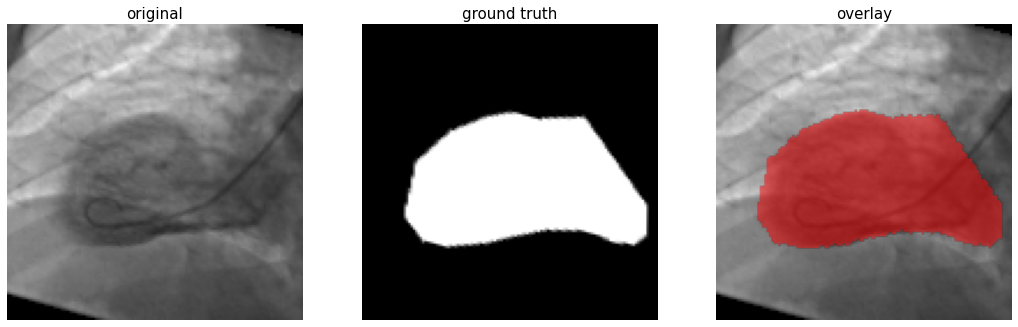

In [96]:
plot_imgs(org_imgs = xx, mask_imgs = yy, nm_img_to_plot = 1 ,figsize = 6)

Model U-net

In [97]:
input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=16,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=4
)


In [98]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  144         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [99]:
model_filename = 'segm_model.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [100]:
model.compile(
    optimizer= Adam(0.0001),
    loss='binary_crossentropy',
    metrics= BinaryAccuracy()
)

In [101]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=50,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

C:\Users\Odin\AppData\Local\Temp\ipykernel_2344\655246040.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: -59.3529 - binary_accuracy: 0.5114
Epoch 1: val_loss improved from inf to -62.27772, saving model to segm_model.h5
100/100 [==============================] - 43s 178ms/step - loss: -59.3529 - binary_accuracy: 0.5114 - val_loss: -62.2777 - val_binary_accuracy: 0.6968
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: -215.1242 - binary_accuracy: 0.6850
Epoch 2: val_loss improved from -62.27772 to -503.16190, saving model to segm_model.h5
100/100 [==============================] - 13s 128ms/step - loss: -215.1242 - binary_accuracy: 0.6850 - val_loss: -503.1619 - val_binary_accuracy: 0.5248
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: -281.5159 - binary_accuracy: 0.6873
Epoch 3: val_loss did not improve from -503.16190
100/100 [==============================] - 13s 128ms/step - loss: -281.5159 - binary_accuracy: 0.6873 - val_loss: -491.2390 - val_binary_accuracy: 0.5435
Epoch 

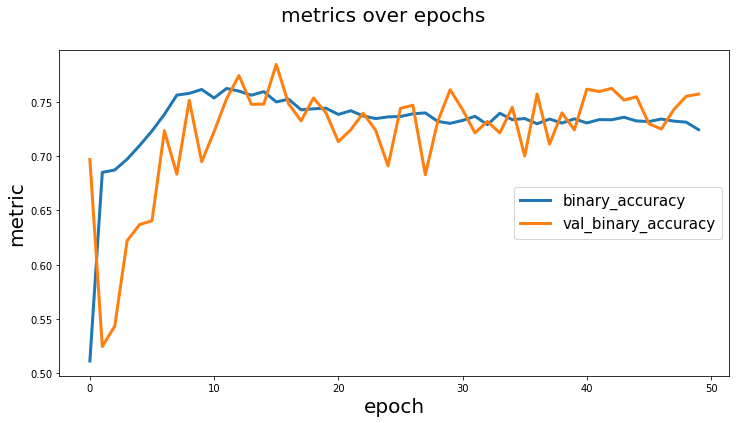

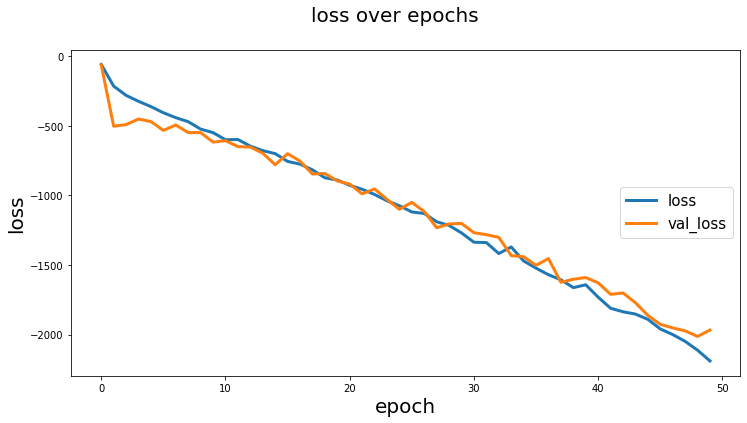

In [102]:
plot_segm_history(history,metrics=['binary_accuracy','val_binary_accuracy'])

In [103]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

In [104]:
def freshape2(xxx):
    return xxx.reshape(xxx.shape[0],xxx.shape[1],xxx.shape[2])

x_val = freshape2(x_val)
y_val = freshape2(y_val)
y_pred = freshape2(y_pred)

print("X_val shape: ", format(x_val.shape))
print("Y_val shape: ", format(y_val.shape))
print("Y_pred: ", format(y_pred.shape))

X_val shape:  (344, 128, 128)
Y_val shape:  (344, 128, 128)
Y_pred:  (344, 128, 128)


In [135]:
def createnewimages(original, masks, prediction):
    alpha = 0.7
    beta = 1-alpha
    img = prediction*255
    img = img.astype('u1')
    overlay = cv2.addWeighted(original, alpha, img, beta, 0.0)
    segmentation = original*prediction

    return [original, masks, prediction, overlay, segmentation]
    

def plot_img(number, original, masks, prediction):
        random.seed(10)
        for i1 in range(number):
            rand1 = random.randint(0,len(original))
            test1 = createnewimages(original[rand1], masks[rand1], prediction[rand1])
            for i in range(len(test1)):
                ax[i1,i].imshow(test1[i], cmap = cm.Greys_r)
                ax[i1,i].axis('off')

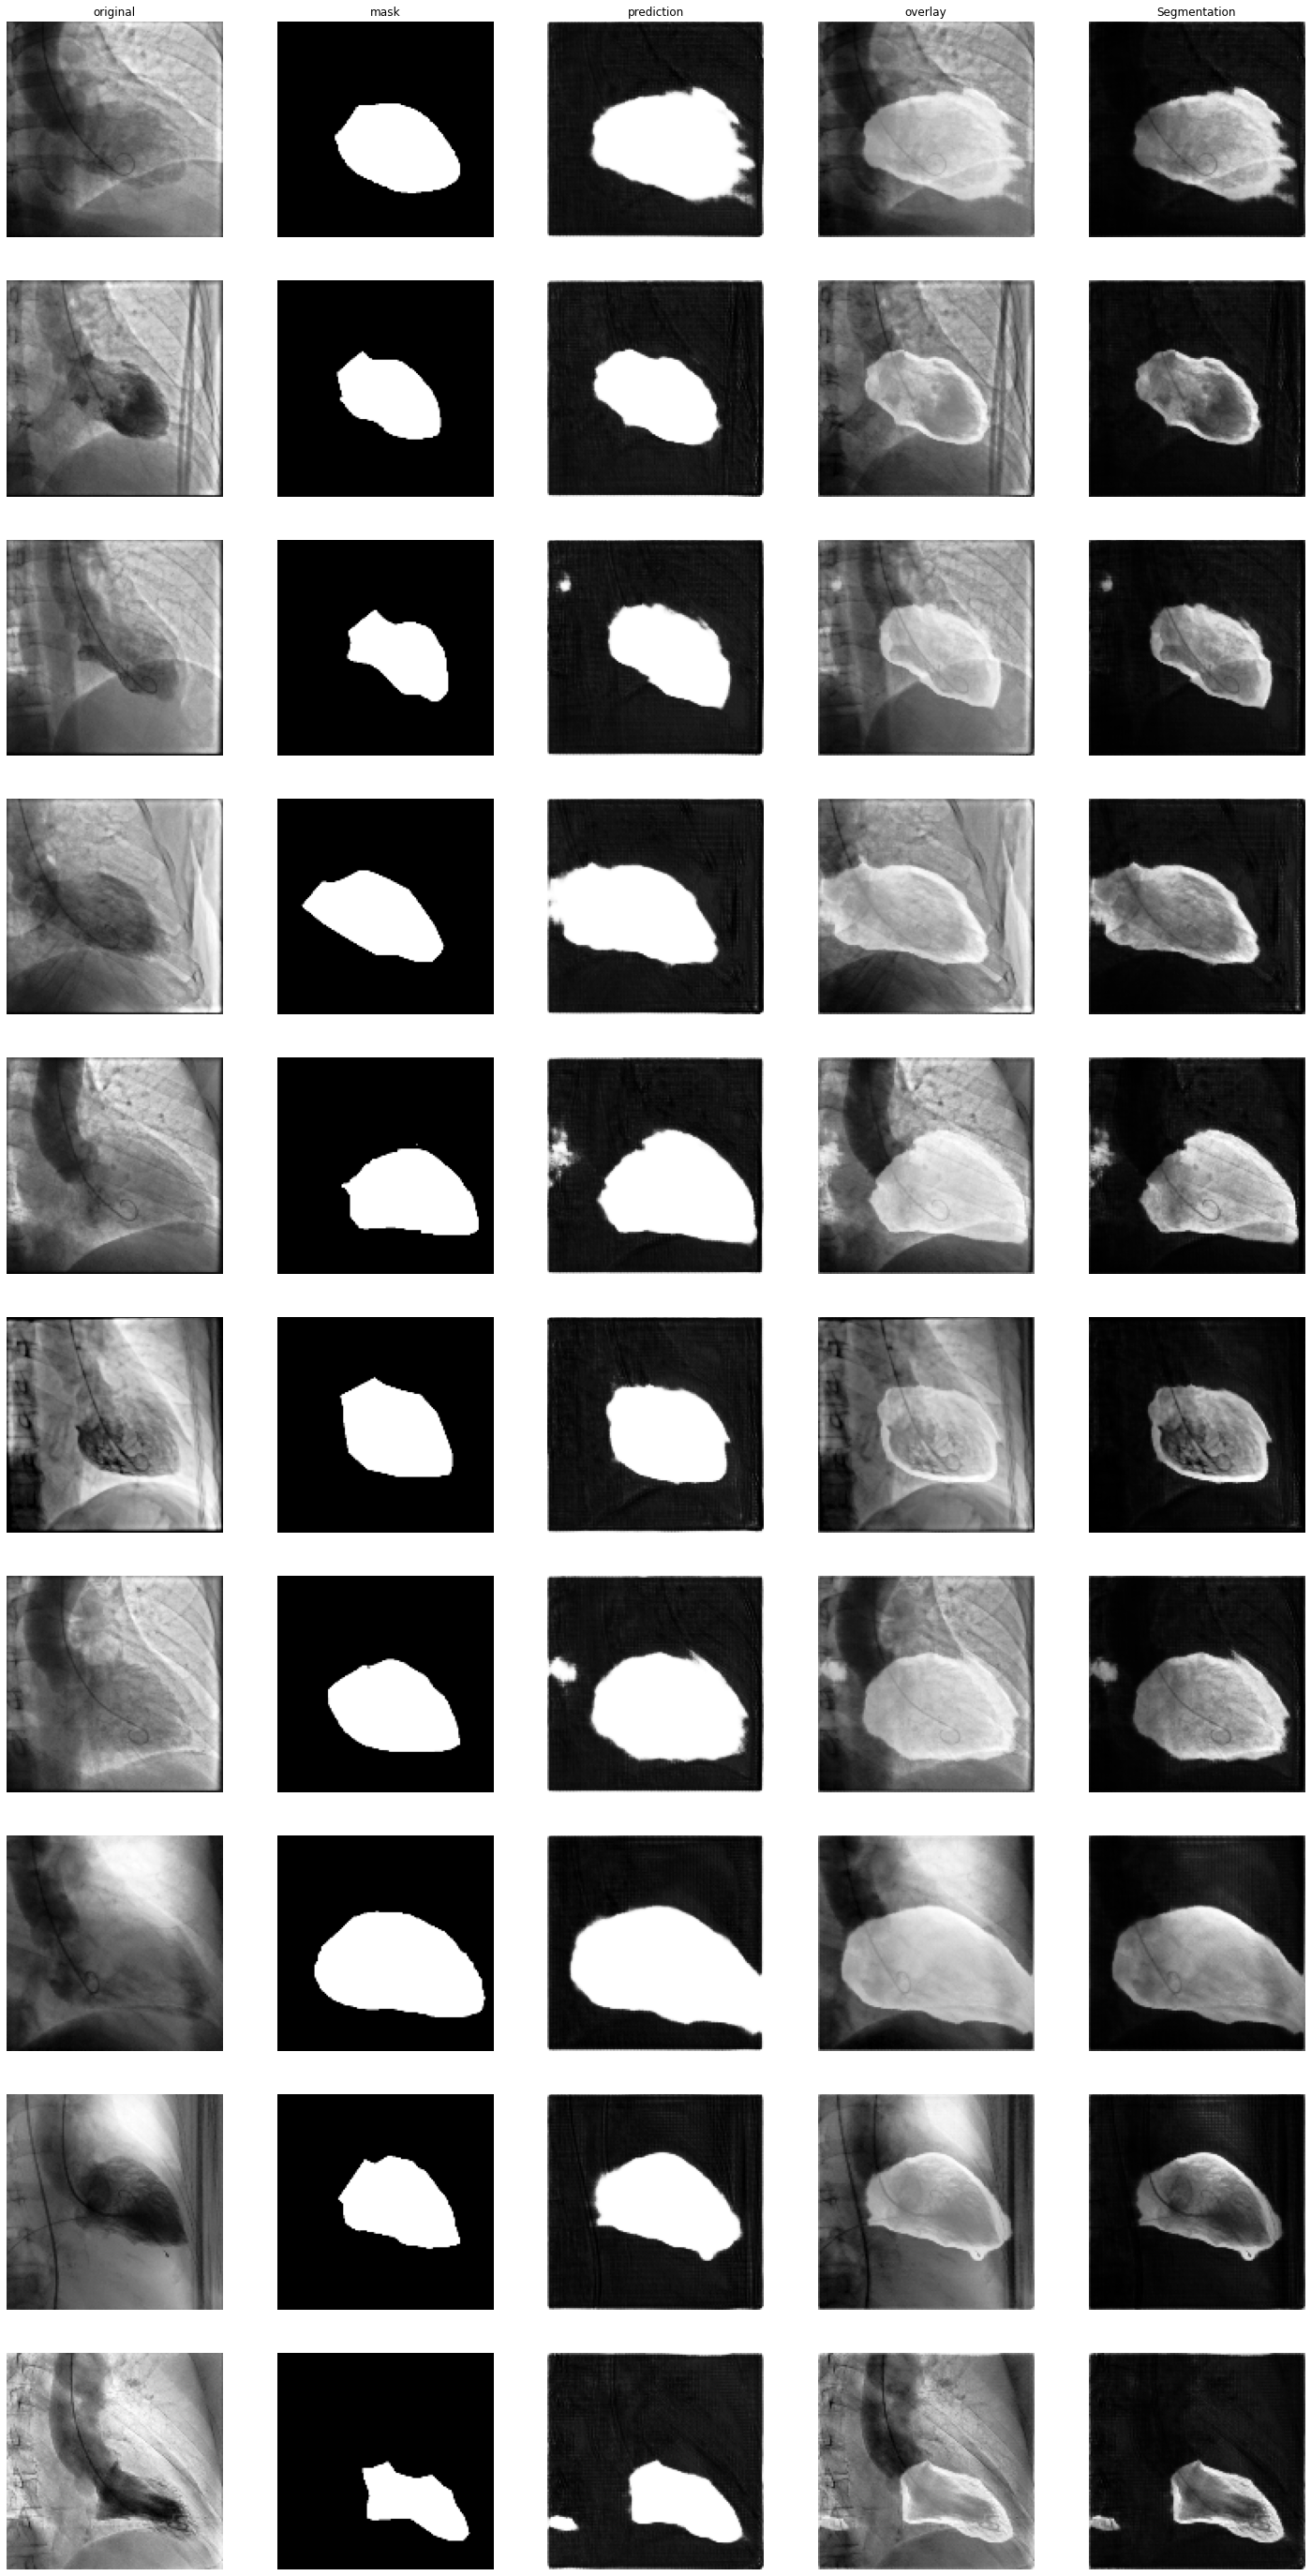

In [136]:
fig, ax = plt.subplots(10, 5, figsize=(25,50))
ax[0,0].title.set_text('original')
ax[0,1].title.set_text('mask')
ax[0,2].title.set_text('prediction')
ax[0,3].title.set_text('overlay')
ax[0,4].title.set_text('Segmentation')

plot_img(10,x_val, y_val, y_pred)

In [137]:
def photo_processing(prediction):
    threshold = 0.5
    maxval = 1
    kernel = np.ones((10,10), dtype=int)
    afterprocessing = []

    for i in range(len(prediction)):
        afterprocessings = cv2.erode(prediction[i], kernel, iterations = 1)
        afterprocessings = (afterprocessings > threshold) * maxval
        afterprocessing.append(afterprocessings)
    afterprocessing = np.array(afterprocessing)

    return(afterprocessing)

In [138]:
photo_after_processing = photo_processing(y_pred)

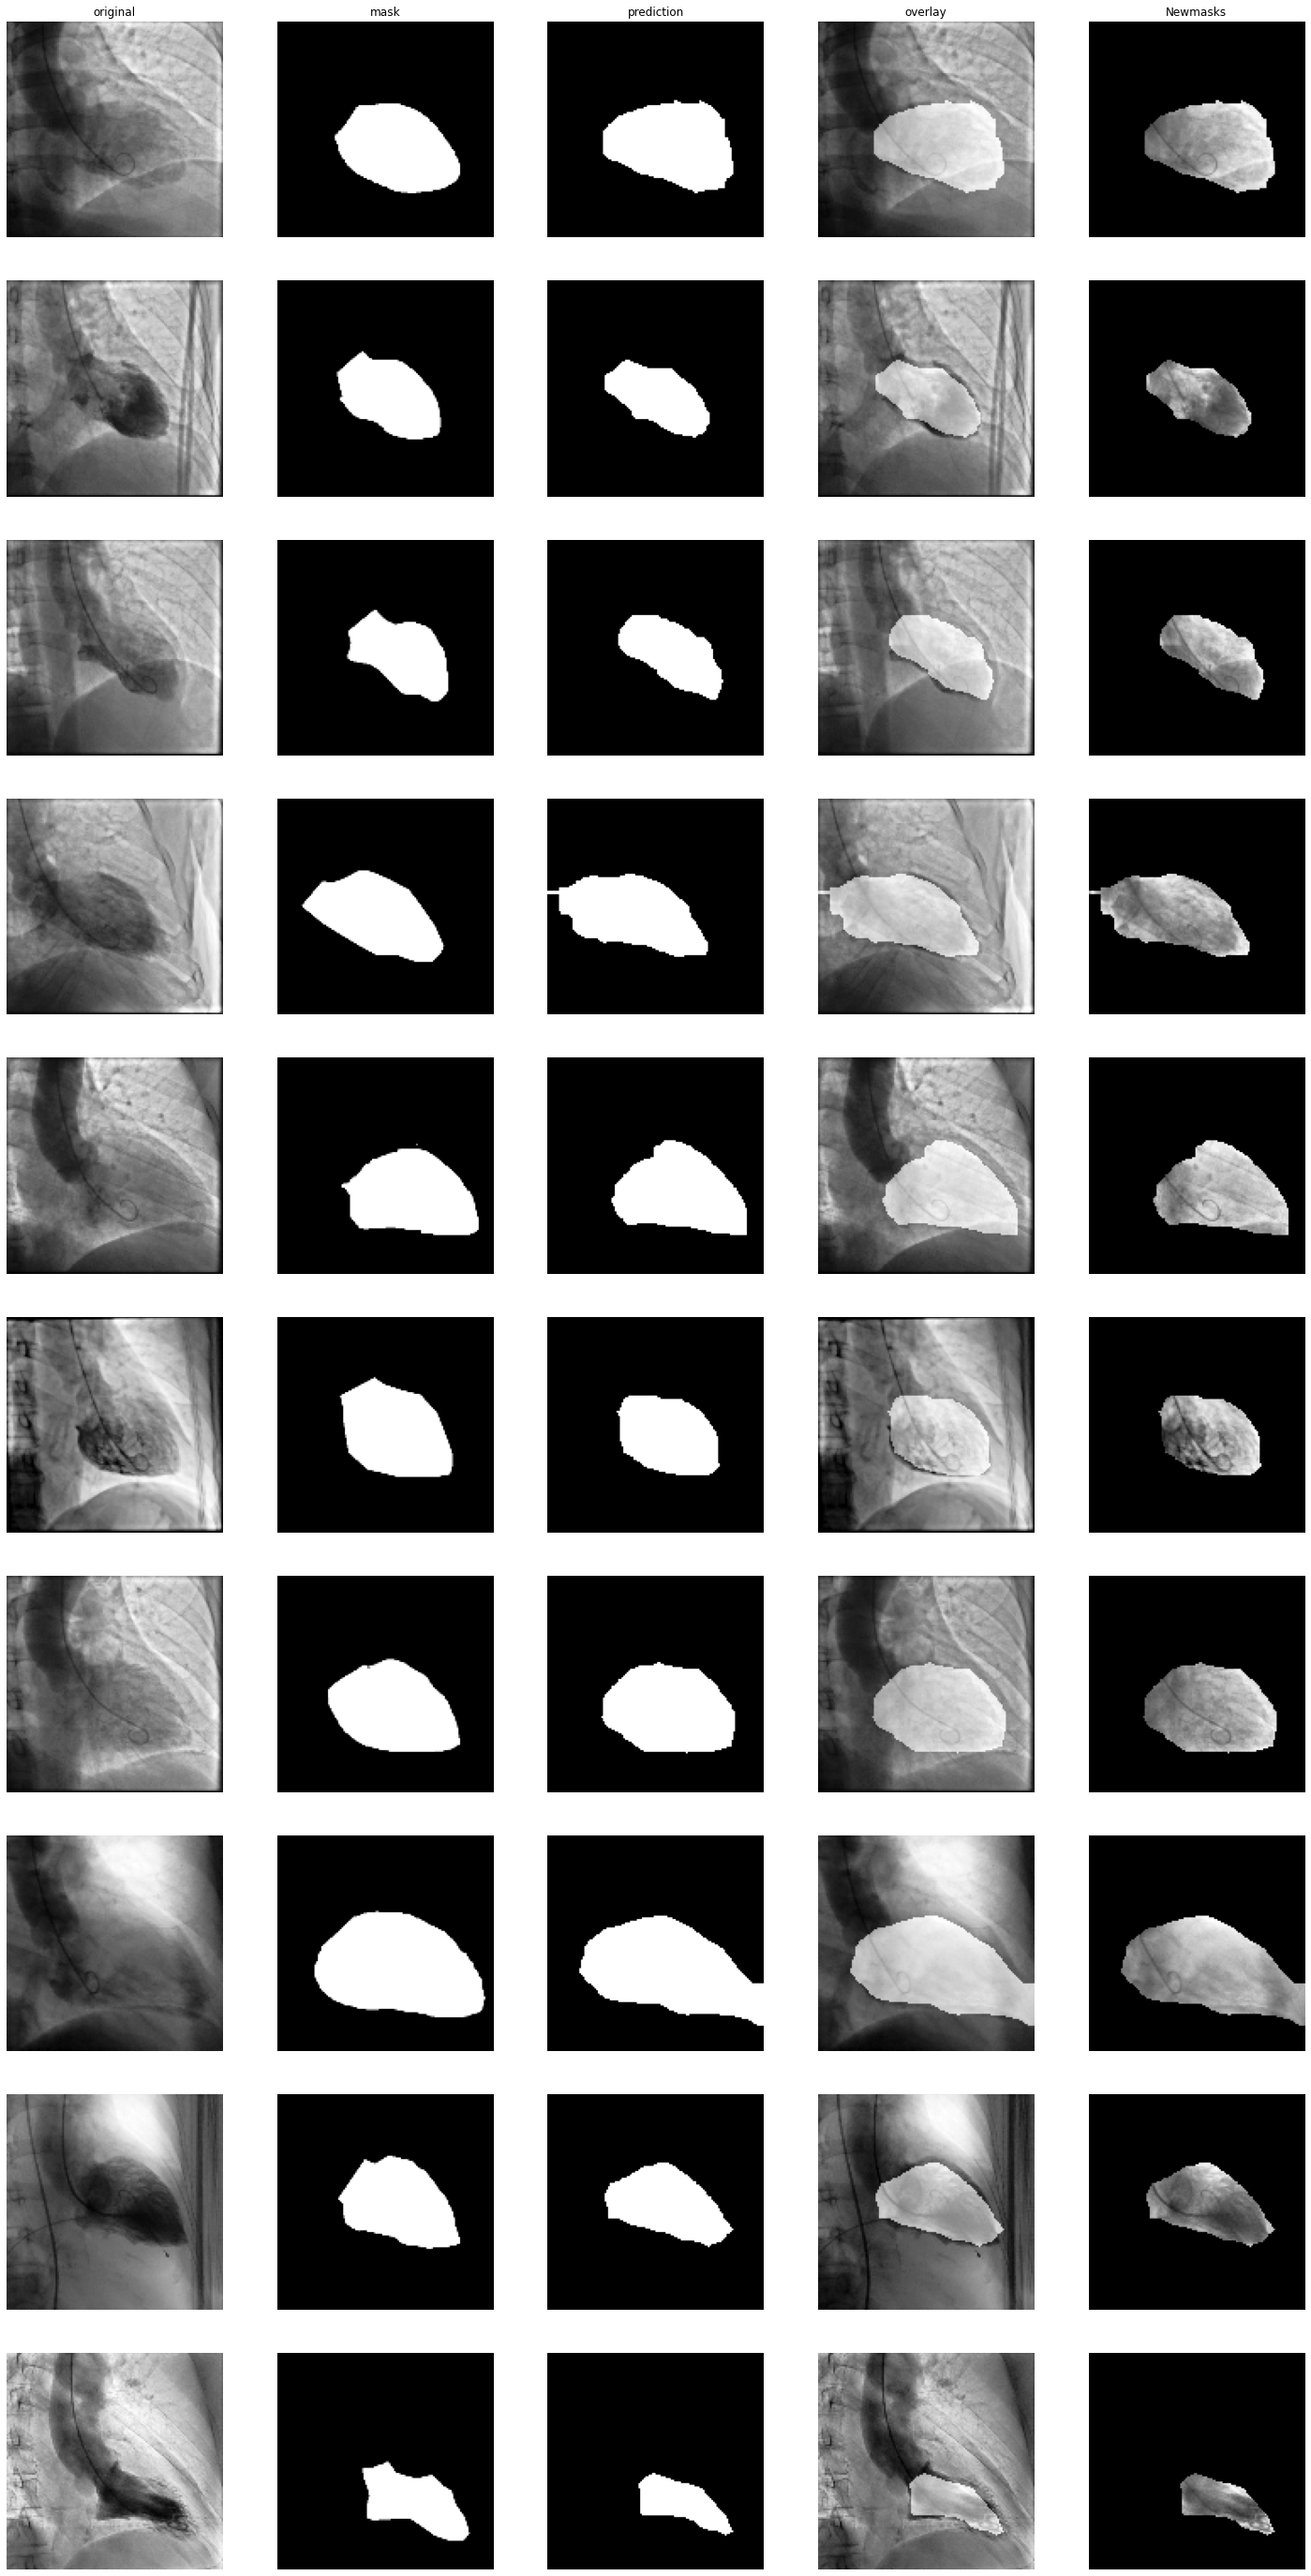

In [139]:
fig, ax = plt.subplots(10, 5, figsize=(25,50))
ax[0,0].title.set_text('original')
ax[0,1].title.set_text('mask')
ax[0,2].title.set_text('prediction')
ax[0,3].title.set_text('overlay')
ax[0,4].title.set_text('Newmasks')

plot_img(10, x_val, y_val, photo_after_processing)

In [140]:
model.load_weights(model_filename)
y_test_pred = model.predict(x_test)

In [141]:
train_score = model.evaluate(x_train,y_train,verbose=0)
val_score = model.evaluate(x_val,y_val,verbose=0)
test_score = model.evaluate(x_test, y_test, verbose = 0)

In [142]:
print('Train loss:', train_score[0]) 
print('Train binary_accuracy:', train_score[1])
print('----------------------------------------')
print('Validation loss:', val_score[0]) 
print('Validation binary_accuracy:', val_score[1])
print('----------------------------------------')
print('Test loss:', test_score[0]) 
print('Test binary_accuracy:', test_score[1])

Train loss: -2070.307373046875
Train binary_accuracy: 0.7538566589355469
----------------------------------------
Validation loss: -578.128662109375
Validation binary_accuracy: 0.7550991177558899
----------------------------------------
Test loss: -2045.781982421875
Test binary_accuracy: 0.7525002956390381
